In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from models.wgangp.wgangp import WGANGP
from models.wgangp.discriminator import Discriminator
from models.wgangp.generator import Generator
from functions import data_reader as dr

C:\Users\louiz\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [2]:
## tf GPU config
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Create a TensorFlow session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

Num GPUs Available:  1


<h2><center>Anime character generation</center></h2>

## I. Reading data

#### 1. Reading images

In [3]:
data_path = 'data/data.zip'

In [4]:
df = dr.read_data(data_path)

100%|██████████████████████████████████████████████████████████████████████████| 63565/63565 [00:43<00:00, 1477.48it/s]


In [5]:
df.shape

(63565, 40, 40, 3)

#### 2. Visualize images

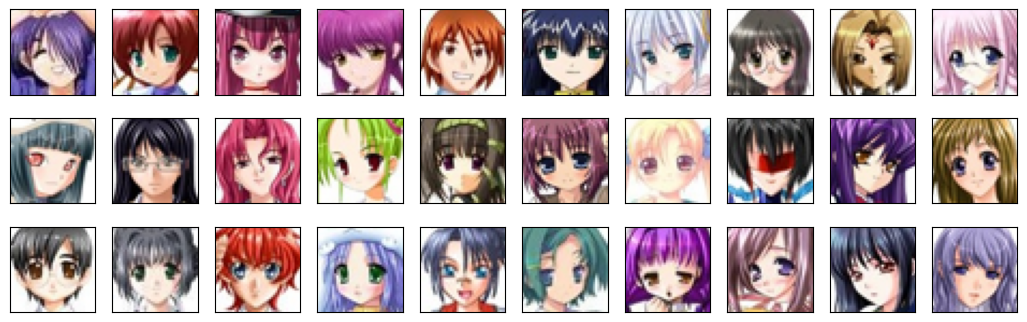

In [6]:
plt.figure(figsize=(13,4))
for i in range(30):
    plt.subplot(3,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(df[i], cmap=plt.cm.binary)
plt.show()

#### 3. Normalize data

In [7]:
X = df/255

In [20]:
X.shape

(63565, 40, 40, 3)

#### 4. Train test split

In [28]:
train_ids = random.sample(range(len(X)), round(0.75*len(X)))
test_ids = list(set(range(len(X))).difference(train_ids))

In [29]:
x_train = X[train_ids]
x_test = X[test_ids]

In [30]:
print(x_train.shape)
print(x_test.shape)

(47674, 40, 40, 3)
(15891, 40, 40, 3)


## II. Train WGANGP

#### 1. Define model parameters

In [21]:
latent_dim = 100
img_shape = (40, 40, 3)

#### 2. Create generator

In [22]:
generator = Generator(latent_dim, img_shape).model

In [23]:
generator.summary()

Model: "conv-generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 6400)              646400    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 6400)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 10, 10, 128)       819328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 20, 20, 64)     

#### 3. Create discriminator

In [24]:
discriminator = Discriminator(img_shape).model

In [25]:
discriminator.summary()

Model: "deconv-discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 40, 40, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        4864      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 128)       204928    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 10, 10, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 10, 12

#### 4. Create model

In [26]:
wgangp = WGANGP(discriminator, generator, latent_dim)
wgangp.compile()

#### 5. Train model

In [31]:
with tf.device('/device:GPU:1'):
    wgangp.fit(x_train, x_train,
               batch_size=32,
               epochs=3,
               )

Epoch 1/3
1490/1490 [==============================] - 314s 198ms/step - d_loss: -0.4822 - g_loss: 2.8030
Epoch 2/3
1490/1490 [==============================] - 331s 222ms/step - d_loss: 0.0258 - g_loss: 2.0953
Epoch 3/3
1490/1490 [==============================] - 336s 226ms/step - d_loss: -0.1769 - g_loss: 1.1514


#### 6. Visualize predictions

In [32]:
random_latent_vectors = tf.random.normal(shape=(30, latent_dim))

In [33]:
pred = wgangp.predict(random_latent_vectors)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

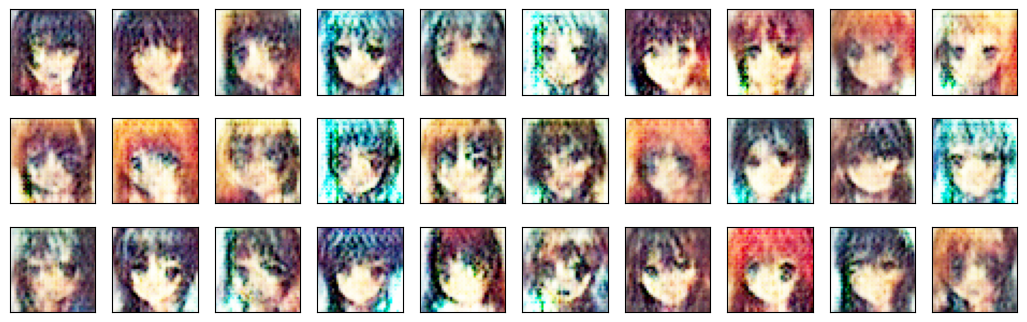

In [34]:
plt.figure(figsize=(13,4))
for i in range(30):
    plt.subplot(3,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(pred[i], cmap=plt.cm.binary)
plt.show()